In [1]:
import pandas as pd
import numpy as np
import joblib
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.model_selection import cross_validate,train_test_split,KFold
from ITMO_FS.filters.univariate import f_ratio_measure,pearson_corr,spearman_corr,kendall_corr
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import RobustScaler,StandardScaler,PowerTransformer
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score,accuracy_score,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns
from sklearn.svm import SVC
import warnings

In [2]:
import torch
import torch.nn as nn
import random

import torchvision
from scipy.sparse import csr_matrix
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(99)
np.random.seed(99)
random.seed(99)

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='finish_model.pkl', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        torch.save(model, self.path)
        self.val_loss_min = val_loss

In [4]:
class MulitiPrototypicalNet3(nn.Module):
    def __init__(self,in_feature,num_class, embedding_dim,
                 support_ratio = 0.6,query_ratio = 0.3,hidden1_dim = 256,hidden2_dim = 128,distance='euclidean'):
        super(MulitiPrototypicalNet3, self).__init__()
        self.num_class = num_class
        self.embedding_dim = embedding_dim
        self.support_ratio = support_ratio
        self.query_ratio = query_ratio
        self.support_num = []
        self.query_num = []
        self.distance = distance
        self.prototype = None
        self.prototypes = []

        self.feature_extraction = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=hidden1_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden1_dim, out_features=hidden2_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden2_dim, out_features=embedding_dim),
        )


    def weights_init_(self):
        for m in self.modules():
            torch.nn.init.xavier_normal_(m.weight, gain=1, )
            torch.nn.init.constant_(m.bias, 0)

    def embedding(self, features):

        result = self.feature_extraction(features)
        return result

    def forward(self, support_input, query_input):

        support_embedding = self.embedding(support_input)
        query_embedding = self.embedding(query_input)
        support_size = support_embedding.shape[0]


        class_meta_dict = {}

        index_tmp = np.cumsum(self.support_num)


        for i in range(0, self.num_class):
            # i  0 , 1, 2, 3,
            start_index = 0 if i == 0 else index_tmp[i-1]
            end_index = index_tmp[i]
            # class_meta_dict[i] = torch.sum(support_embedding[i * every_class_num:(i + 1) * every_class_num, :],
            #                                dim=0) / self.support_num[i]

            # print((start_index,end_index))

            class_meta_dict[i] = torch.sum(support_embedding[start_index:end_index, :],
                                           dim=0) / self.support_num[i]

        class_meta_information = torch.zeros(size=[len(class_meta_dict), support_embedding.shape[1]])
        for key, item in class_meta_dict.items():
            class_meta_information[key, :] = class_meta_dict[key]

        N_query = query_embedding.shape[0]
        result = torch.zeros(size=[N_query, self.num_class])

        self.prototype = class_meta_information
        self.prototypes.append(class_meta_information.detach().numpy())

        for i in range(0, N_query):
            temp_value = query_embedding[i].repeat(self.num_class, 1)
            dist_value = F.pairwise_distance(self.prototype, temp_value, p=2)
            result[i] = -1 * dist_value
        return result

    def randomGenerate(self, X, Y):

        support_index = []
        for i in range(self.num_class):

            support_index.extend(np.random.choice(np.where(Y == i)[0], self.support_num[i],
                                                  replace=False))

        support_index = np.array(support_index)
        support_input = X[support_index, :]
        support_label = Y[support_index]

        query_index = []
        for i in range(self.num_class):
            query_index.extend(np.random.choice([index for index in np.where(Y == i)[0] if
                                                 index not in support_index],
                                                self.query_num[i], replace=False))
        query_index = np.array(query_index)
        query_input = X[query_index]
        query_label = Y[query_index]

        support_input = torch.tensor(support_input, dtype=torch.float)
        query_input = torch.tensor(query_input, dtype=torch.float)
        support_label = torch.tensor(support_label, dtype=torch.long)
        query_label = torch.tensor(query_label, dtype=torch.long)

        return support_input, query_input, support_label, query_label

    
    def fit(self,X_train,y_train,X_valid,y_valid,optimizer,criterion,patience,EPOCH):

        for i in range(self.num_class):
            cur_y_count = sum(y_train == i)
            self.support_num.append(int(cur_y_count * self.support_ratio ))
            self.query_num.append(int(cur_y_count * self.query_ratio))

        # patience = patience  # 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
        early_stopping = EarlyStopping(patience, verbose=True, path="finish_model_1.pkl")        
        
        loss_list = []
        
        for epoch in range(EPOCH):
            self.train()
            support_input, query_input, support_label, query_label = \
                self.randomGenerate(X_train,y_train)

            output = self.forward(support_input, query_input)
            loss = criterion(output, query_label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        
        
            pre_valid_y, prob_valid_y = self.predict(X_valid)
            auc = roc_auc_score(y_valid, prob_valid_y)
            
            
            # print("Epoch: {:04d}".format(epoch), "acc:{:.4f}".format(1 - error)      
            
            early_stopping(1-auc, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
            print("Epoch number:{},Current loss:{:.4f},Current accuracy:{:.4f}\n".format(epoch, loss.item(),auc))
        
        return loss_list
    

    def predict(self,X_test):

        self.eval()
        X_test = torch.tensor(X_test, dtype=torch.float32)
        X_embedding = self.embedding(X_test)
        result = torch.zeros(size=[X_embedding.shape[0], self.num_class])
        for i in range(0, X_embedding.shape[0]):

            temp_value = X_embedding[i].repeat(self.num_class, 1)
            dist_value = 0
            if self.distance == 'euclidean':
                dist_value = F.pairwise_distance(self.prototype, temp_value, p=2)
            elif self.distance == 'cosine':
                dist_value = torch.cosine_similarity(self.prototype, temp_value, dim=1)
                dist_value = 1 - dist_value
                  
            result[i] = -1 * dist_value
                  
        result = F.softmax(result, dim=1)

        pre_Y = torch.argmax(result, dim=1).detach().numpy().astype(int)
        prob_Y = result[:,1].detach().numpy()
        return pre_Y, prob_Y


def protoNet_visualie2(model, X,Y,class_num, c, label):

    prototypical = model.prototypes

    X = torch.tensor(X, dtype=torch.float)
    X_transform = model.embedding(X)
    # pre_Y, prob_Y = model.predict(X)
    print(X_transform.shape)

    plt.figure()
    for i in range(class_num):
        cur_index = np.where(Y == i)[0]
        cur_X = X_transform.detach().numpy()[cur_index, :]
        plt.scatter(cur_X[:, 0], cur_X[:, 1], c=c[i], label=label[i])

    plt.title("ProtoTypicalNet Output Visualization", )
    plt.legend()
    plt.show()
    
def miv(model, X):
    model.eval()
    miv = torch.ones(X.shape[1])
    for i in range(X.shape[1]):

        cur_X_1 = X.copy()
        cur_X_2 = X.copy()

        cur_X_1[:, i] = cur_X_1[:, i] + cur_X_1[:, i] * 0.1
        cur_X_2[:, i] = cur_X_2[:, i] - cur_X_2[:, i] * 0.1

        # cur_X_1 = np.log1p(cur_X_1)
        # cur_X_2 = np.log1p(cur_X_2)
        # std = StandardScaler()
        # cur_X_1 = std.fit_transform(cur_X_1)
        # cur_X_2 = std.fit_transform(cur_X_2)
        cur_X_1 = torch.tensor(cur_X_1, dtype=torch.float)
        cur_X_2 = torch.tensor(cur_X_2, dtype=torch.float)

        cur_diff = torch.mean(model.embedding(cur_X_1) - model.embedding(cur_X_2), dim=1)
        miv[i] = torch.mean(cur_diff, dim=0)

    s = torch.abs(miv) / torch.sum(torch.abs(miv))
    rank = torch.argsort(torch.abs(miv), dim=0, descending=True)
    return rank, s
    

In [5]:
admet = pd.read_excel('../data/ADMET.xlsx',sheet_name="training",engine='openpyxl',index_col=0,)
admet.head()

,Caco-2,CYP3A4,hERG,HOB,MN
SMILES,,,,,
Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5CCCCC5)cc4,0,1,1,0,0
Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN5CCCCC5)cc4,0,1,1,0,0
Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN5CCCCC5)cc4,0,1,1,0,1
Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCCN5CCCCC5)cc4,0,1,1,0,0
Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCCN5CCCCC5)cc4,0,1,1,0,0


############ 第一个  Caco-2 ###########

In [ ]:
molecular_des_corr_del = pd.read_csv("../第一题/molecular_des_corr_del.csv",index_col=0)
all_data = molecular_des_corr_del.join(admet)
X = all_data.iloc[:,:-5].values
y = all_data.iloc[:,-5].values
X.shape

In [7]:
np.sum(y)    ### 1的个数

759

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.3, stratify=y,random_state=56)
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_valid = ss.transform(X_valid)
joblib.dump(ss, 'p1_ss.pkl')

['p1_ss.pkl']

In [9]:
model = MulitiPrototypicalNet3(X_train.shape[1],2, 24,)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
model.fit(X_train,y_train,X_valid,y_valid,optimizer,criterion,50,500)
pre_Y, prob_Y = model.predict(X_valid)

/home/dell/.conda/envs/shumo/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Validation loss decreased (inf --> 0.137455).  Saving model ...
Epoch number:0,Current loss:0.6884,Current accuracy:0.8625

Validation loss decreased (0.137455 --> 0.107919).  Saving model ...
Epoch number:1,Current loss:0.6758,Current accuracy:0.8921

Validation loss decreased (0.107919 --> 0.101995).  Saving model ...
Epoch number:2,Current loss:0.6465,Current accuracy:0.8980

Validation loss decreased (0.101995 --> 0.099447).  Saving model ...
Epoch number:3,Current loss:0.6116,Current accuracy:0.9006

Validation loss decreased (0.099447 --> 0.097537).  Saving model ...
Epoch number:4,Current loss:0.5649,Current accuracy:0.9025

Validation loss decreased (0.097537 --> 0.094929).  Saving model ...
Epoch number:5,Current loss:0.5381,Current accuracy:0.9051

Validation loss decreased (0.094929 --> 0.093103).  Saving model ...
Epoch number:6,Current loss:0.4855,Current accuracy:0.9069

Validation loss decreased (0.093103 --> 0.090399).  Saving model ...
Epoch number:7,Current loss:0.470

In [10]:
final_model1 = torch.load("./finish_model_1.pkl")
pre_valid_y_model1, prob_valid_y_model1 = final_model1.predict(X_valid)
acc = accuracy_score(y_valid, pre_valid_y_model1)
auc = roc_auc_score(y_valid,prob_valid_y_model1)
print('acc:   ' + str(acc))
print('auc:   ' + str(auc))

acc:   0.9207419898819561
auc:   0.9722182167748137


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.3, stratify=y,random_state=56)
p2_ss = joblib.load("p2_ss.pkl")
pn_model2 = torch.load("./finish_model_1.pkl")
X_valid = p2_ss.transform(X_valid)
accuracy_score(pn_model2.predict(X_valid)[0],y_valid)

0.9224283305227656

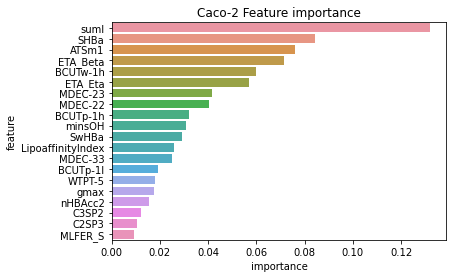

In [20]:
rank,s = miv(final_model1,X_train)
show_feature_num = 20

f_importance = pd.DataFrame({"feature": molecular_des_corr_del.columns,"importance": s.detach().numpy()})
f_importance = f_importance.sort_values(by="importance", ascending=False)
# print(f_importance)
f_importance = f_importance[:show_feature_num]
p = sns.barplot(x="importance", y="feature", data=f_importance,
            order=f_importance["feature"],orient="h",)
p.set_title('Caco-2 Feature importance')
bar_fig = p.get_figure()
bar_fig.savefig("png_Caco-2 Feature importance.png",dpi=400)
plt.show()
f_importance.to_csv("Caco-2 Feature importance.csv")

In [13]:
rank

tensor([ 36,  68, 127,  81, 117,  75, 100,  99, 119,  59,  49,  63,  95, 120,
        132,  21, 134, 109, 112, 124, 131, 136,   9,  88,  62, 123, 110,  54,
         64,  90,   0, 135,  11,  32,  85,  22, 133, 121, 104,  24,  50,  15,
         37, 126,  39,  26,  53, 101,   6,  25,  55,  80,  69,  79, 107,  61,
         35, 122,  42,  44,  45,  87,  13,   7,  19,   1,  58,  52,   8,  84,
         86,  73,  51,  17,  27,  65,  78,  66,  30,  74,  23,  12,  29,  71,
        128,  89,  10,  70,  92, 108,  20,  67, 125,  82,  47,  83,  91,  93,
         14,  97,  40, 105, 113, 106,   5,  48,   3,  33,  60,  28,  76, 116,
         43,   4,  16, 115, 103,  38,  46,  57, 111, 118,  96,  56,  94,  41,
         98,  18,  34,   2,  77, 102,  72, 130, 114,  31, 129])

In [14]:
molecular_test = pd.read_excel('../data/Molecular_Descriptor.xlsx',sheet_name="test",engine='openpyxl',index_col=0,)
molecular_test.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
SMILES,,,,,,,,,,,,,,,,,,,,,
COc1cc(OC)cc(\C=C\c2ccc(OS(=O)(=O)[C@@H]3C[C@@H]4O[C@H]3C(=C4c5ccc(O)cc5)c6ccc(O)cc6)cc2)c1,0,1.8193,3.309852,177.6817,89.159790,24,24,73,43,30,...,598.166139,88.708522,2.062989,25.464529,21.942236,0.0,7421,70,2.526,236
OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3ccccc23)c4ccc(O)cc4,1,2.7289,7.446895,125.0445,60.543860,18,18,49,29,20,...,384.136159,59.883849,2.064960,10.441277,10.441277,0.0,2217,49,3.681,152
COc1ccc2C(=C(CCOc2c1)c3ccc(O)cc3)c4ccc(\C=C\C(=O)O)cc4,1,2.2303,4.974238,131.6880,64.439446,18,18,53,31,22,...,414.146724,63.762531,2.056856,13.254618,13.254618,0.0,2661,53,3.710,162
OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)c4ccc(O)cc4,1,2.6387,6.962738,125.1723,60.434067,18,18,49,30,19,...,402.126737,61.734159,2.057805,12.992047,10.440839,0.0,2424,51,3.586,158
OC(=O)\C=C\c1ccc(cc1)C2=C(CCSc3cc(F)ccc23)c4ccc(O)cc4,1,3.3834,11.447396,131.3467,62.532067,18,18,49,30,19,...,418.103894,61.734159,2.057805,12.992047,7.310754,0.0,2424,51,3.978,158


In [15]:
final_test_coulmns = molecular_des_corr_del.columns.tolist()

In [16]:
final_test = molecular_test.loc[:,final_test_coulmns].values
final_test

array([[ 1.        ,  3.        , -1.90206504, ...,  8.        ,
         3.30985249,  6.07537   ],
       [ 2.        ,  0.        ,  0.        , ...,  4.        ,
         7.44689521,  4.99117   ],
       [ 2.        ,  0.        ,  0.        , ...,  5.        ,
         4.97423809,  4.99977   ],
       ...,
       [ 5.        ,  1.        ,  0.        , ...,  6.        ,
         3.57361216,  5.08198   ],
       [ 7.        ,  1.        ,  0.        , ...,  7.        ,
         0.73667889,  6.19927   ],
       [ 8.        ,  1.        ,  0.        , ...,  3.        ,
         7.74341929,  6.50928   ]])

In [17]:
p2_ss = joblib.load("p2_ss.pkl")
pn_model2 = torch.load("./finish_model_1.pkl")
final_test = p2_ss.transform(final_test)
for i in pn_model2.predict(final_test)[0]:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
